# Facial Emotion Recognition | SIFT+SVM

### Imports

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.model_selection import train_test_split
from skimage import img_as_ubyte, io, color
from sklearn.cluster import MiniBatchKMeans
from sklearn import svm, metrics
from joblib import dump

### Gathering the data and labels which are added to lists and returned by the *get_data* funtion

In [2]:
train_path = 'CW_Dataset_current/train'
test_path = 'CW_Dataset_current/test'

"""
This get_data function was used from the tutorial, however heavily modified to suit my needs
"""
def get_data(folder_path):
    print("Fetching data...")
    images = []
    labels = []
    folder_names = [folder for folder in sorted(os.listdir(folder_path)) if not folder.startswith('.')]
    
    for folder in folder_names:
        file_names = [file for file in sorted(os.listdir(os.path.join(folder_path, folder))) if file.endswith('.jpg')]
        for file in file_names:    
            images.append(io.imread(os.path.join(folder_path, folder, file)))
            labels.append(folder)
    
    print("Done!")
    return images, labels

### Caling the *get_data* function from above and storing the images and labels into *X* and *y*

In [3]:
X, y = get_data(train_path)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

Fetching data...
Done!


### Gathering feature descriptors for each image and adding them to an array

Identifying keypoints and extracting the descriptors...
Feature Descriptor time: 18.68086528778076s


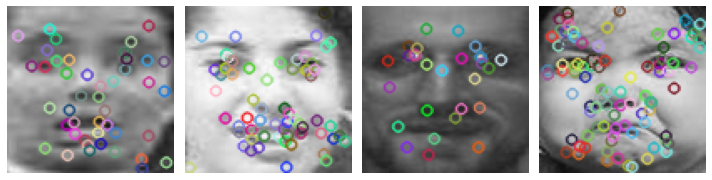

Done!


In [4]:
start_time = time.time()
print("Identifying keypoints and extracting the descriptors...")
"""
The following block of code up until the end mark was provided from the tutorials, with minor modifications from me
"""
sift = cv2.SIFT_create()

des_list_train = []
y_train_list = []

fig, ax = plt.subplots(1, 4, figsize=(10, 8), sharey=True)

#Looping through identifying keypopints and extracting the descriptors
for i in range(len(X_train)):
    img = img_as_ubyte(color.rgb2gray(X_train[i]))
    kp, des = sift.detectAndCompute(img, None)
    
    #Showing the results for the first 4 images
    if i<4:
        img_with_SIFT = cv2.drawKeypoints(img, kp, img)
        ax[i].imshow(img_with_SIFT)
        ax[i].set_axis_off()
        
    #Append list of descriptors and label to respective lists
    if des is not None:
        des_list_train.append(des)
        y_train_list.append(y_train[i])

print(f"Feature Descriptor time: {time.time() - start_time}s")
fig.tight_layout()
plt.show()

#Convert to array for easier handling
des_array_train = np.vstack(des_list_train)
"""
End Block
"""
print("Done!")

### For Bag of Visual Words we need to cluster the descriptors to create histograms of codewords

Clustering descriptors...
Done!
Converting descriptors into histogram codewords...
Histogram of codewords time: 87.59175777435303s


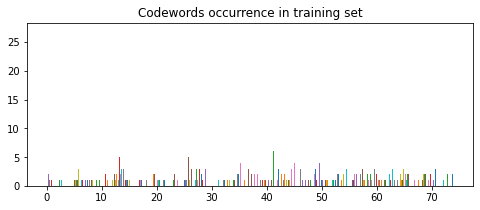

Done!


In [5]:
#Clustering descriptos to create codewords using K-Means
print("Clustering descriptors...")
k = 75

"""
The following block of code up until the end mark was provided by the tutorials, with minor modifications from me
"""

#Using MiniBatchKMeans for faster computation and lower memory usage
batch_size = des_array_train.shape[0] // 4
kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size).fit(des_array_train)
print("Done!")

#Convert descriptors into histograms of codewords for each image
print("Converting descriptors into histogram codewords...")
hist_list_train = []
idx_list_train = []

for des in des_list_train:
    hist = np.zeros(k)

    idx = kmeans.predict(des)
    idx_list_train.append(idx)
    for j in idx:
        hist[j] = hist[j] + (1 / len(des))
    hist_list_train.append(hist)

hist_array_train = np.vstack(hist_list_train)

print(f"Histogram of codewords time: {time.time() - start_time}s")

#Plotting the overall occurance of codewords in the training set
fig, ax = plt.subplots(figsize=(8, 3))
ax.hist(np.array(idx_list_train, dtype=object), bins=k)
ax.set_title('Codewords occurrence in training set')
plt.show()

"""
End block
"""

print("Done!")

### Training a SVC and fitting it to the histograms created in the previous cell and their labels

In [9]:
#Training a classifier
start_time = time.time()

print("Training support vector classifier...")
classifier = svm.SVC(kernel='rbf')
classifier.fit(hist_array_train, y_train_list)
print("Done!")

print(f"Training time: {time.time() - start_time}s")

Training support vector classifier...
Done!
Training time: 6.053857088088989s


### Pickling the Model

In [7]:
print("Dumping the model...")
dump((classifier, k, kmeans), 'SIFT-SVM.joblib') 
print("Done!")

Dumping the model...
Done!


### Testing the model on the testing part of the dataset and displaying the outputs. NOTE: We also create a list of histograms here for the testing images

Testing the model on the test set...
Testing time: 7.678436040878296


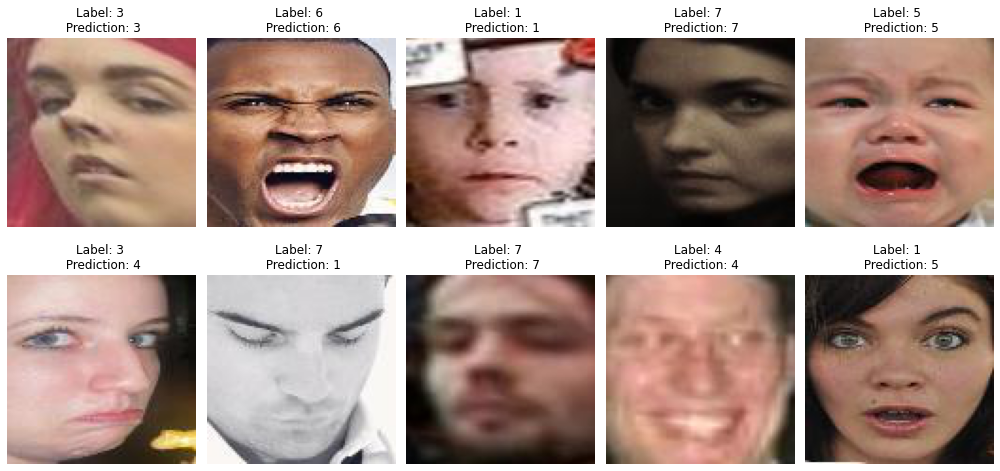


Label explanation:
1: Surprise
2: Fear
3: Disgust
4: Happiness
5: Sadness
6: Anger
7: Neutral
      
Classification report for classifier SVC():
                    precision    recall  f1-score   support

           1       0.43      0.45      0.44       300
           2       0.76      0.85      0.80       299
           3       0.61      0.62      0.61       300
           4       0.36      0.35      0.36       300
           5       0.32      0.25      0.28       300
           6       0.55      0.63      0.59       300
           7       0.38      0.35      0.37       298

    accuracy                           0.50      2097
   macro avg       0.49      0.50      0.49      2097
weighted avg       0.49      0.50      0.49      2097


Done! End of Program.


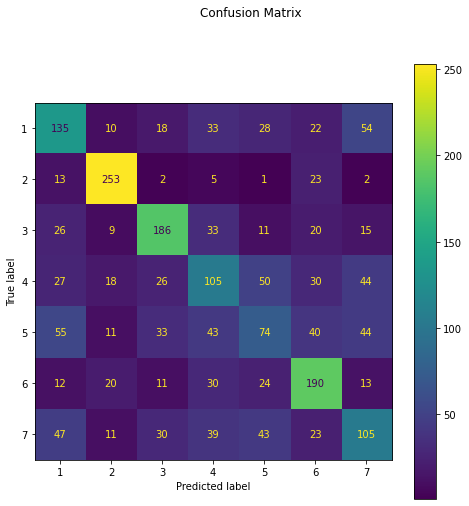

In [10]:
#Starting testing time
start_time = time.time()

#Testing the model on the test set
print("Testing the model on the test set...")

"""
The following block of code until the end mark was provided from the tutorials, with minor modification from me
"""

hist_list_test = []
for i in range(len(X_test)):
    img = img_as_ubyte(color.rgb2gray(X_test[i]))
    kp, des = sift.detectAndCompute(img, None)

    if des is not None:
        hist = np.zeros(k)

        idx = kmeans.predict(des)

        for j in idx:
            hist[j] = hist[j] + (1 / len(des))

        hist_list_test.append(hist)

    else:
        hist_list_test.append(None)
        
#Remove potential cases of images with no descriptors
idx_not_empty = [i for i, x in enumerate(hist_list_test) if x is not None]
hist_list_test = [hist_list_test[i] for i in idx_not_empty]
y_test_list = [y_test[i] for i in idx_not_empty]
hist_array_test = np.vstack(hist_list_test)

#classifier = load('SIFT-SVM.joblib')
predicted = classifier.predict(hist_array_test).tolist()

print(f"Testing time: {time.time() - start_time}")

fig, axes = plt.subplots(2, 5, figsize=(14, 7), sharex=True, sharey=True)
ax = axes.ravel()

for i in range(10):
    ax[i].imshow(X_test[i])
    ax[i].set_title(f'Label: {y_test_list[i]} \n Prediction: {predicted[i]}')
    ax[i].set_axis_off()
fig.tight_layout()
plt.show()

"""
End block
"""

print("""
Label explanation:
1: Surprise
2: Fear
3: Disgust
4: Happiness
5: Sadness
6: Anger
7: Neutral
      """)
print(f"""Classification report for classifier {classifier}:
      {metrics.classification_report(y_test_list, predicted)}\n""")
print("Done! End of Program.")

fig, ax = plt.subplots(figsize=(8, 8))
disp = metrics.plot_confusion_matrix(classifier, hist_array_test, y_test_list,
                                     values_format = 'd', ax=ax)
disp.figure_.suptitle("Confusion Matrix")
plt.show()